/var/folders/fg/t6lktxg91c5b91pyb0rk6x080000gn/T/ipykernel_59087/520496747.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  new = pd.read_csv(new_path)


=== Basic comparison: nodes and rows ===
New (B77_spearman): 7,726 unique nodes, 198,200 rows
Old (B77_huber_reg): 6,615 unique nodes, 176,945 rows
New approach has 1111 MORE unique nodes than old approach.
New approach has 21255 MORE rows (observations) than old approach.

=== Spearman comparison on overlapping nodes ===
Nodes present in BOTH datasets (with valid Spearman): 5,851
Nodes where NEW approach has higher Spearman: 2,299
Nodes where OLD approach has higher Spearman: 2,397
Nodes where Spearman is equal: 1,155

Median Spearman (all nodes in each dataset):
  New (spearman_rho): 0.666
  Old (spearman_corr): 0.657

Median Spearman (only overlapping node_ids):
  New (spearman_rho, overlap): 0.666
  Old (spearman_corr, overlap): 0.678


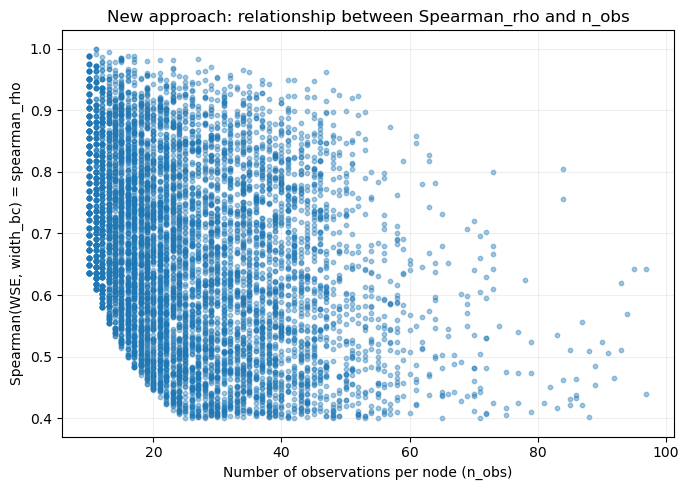

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Load both CSVs
# --------------------------------------------------------------------
new_path = "/Users/daniel/Downloads/B77_spearman.csv"      # new approach (Spearman step)
old_path = "/Volumes/Science_SSD/Dissertation/3_output/Global_22_07_25/simple/B77_huber_reg.csv"     # old Huber-regression-based approach

new = pd.read_csv(new_path)
old = pd.read_csv(old_path)

# Basic sanity check
assert "node_id" in new.columns, "node_id missing in B77_spearman.csv"
assert "node_id" in old.columns, "node_id missing in B77_huber_reg.csv"
assert "spearman_rho" in new.columns, "spearman_rho missing in B77_spearman.csv"
assert "spearman_corr" in old.columns, "spearman_corr missing in B77_huber_reg.csv"

# --------------------------------------------------------------------
# 2. Compare unique nodes and total observations
# --------------------------------------------------------------------
unique_nodes_new = new["node_id"].nunique()
unique_nodes_old = old["node_id"].nunique()

rows_new = len(new)
rows_old = len(old)

diff_nodes = unique_nodes_new - unique_nodes_old
diff_rows = rows_new - rows_old

def _diff_text(diff, thing):
    if diff > 0:
        return f"New approach has {diff} MORE {thing} than old approach."
    elif diff < 0:
        return f"New approach has {-diff} FEWER {thing} than old approach."
    else:
        return f"Both approaches have the SAME number of {thing}."

print("=== Basic comparison: nodes and rows ===")
print(f"New (B77_spearman): {unique_nodes_new:,} unique nodes, {rows_new:,} rows")
print(f"Old (B77_huber_reg): {unique_nodes_old:,} unique nodes, {rows_old:,} rows")
print(_diff_text(diff_nodes, "unique nodes"))
print(_diff_text(diff_rows, "rows (observations)"))
print()

# --------------------------------------------------------------------
# 3. Compare Spearman on overlapping nodes
# --------------------------------------------------------------------
# Use one row per node_id for Spearman columns (in case there are duplicates)
new_spear = (
    new[["node_id", "spearman_rho"]]
    .drop_duplicates(subset=["node_id"])
    .dropna(subset=["spearman_rho"])
)

old_spear = (
    old[["node_id", "spearman_corr"]]
    .drop_duplicates(subset=["node_id"])
    .dropna(subset=["spearman_corr"])
)

overlap = new_spear.merge(
    old_spear,
    on="node_id",
    how="inner",
    suffixes=("_new", "_old"),
)

# Drop any nodes where either Spearman is NaN
overlap = overlap.dropna(subset=["spearman_rho", "spearman_corr"])

n_overlap = len(overlap)

n_new_better = int((overlap["spearman_rho"] > overlap["spearman_corr"]).sum())
n_old_better = int((overlap["spearman_rho"] < overlap["spearman_corr"]).sum())
n_equal      = int((overlap["spearman_rho"] == overlap["spearman_corr"]).sum())

print("=== Spearman comparison on overlapping nodes ===")
print(f"Nodes present in BOTH datasets (with valid Spearman): {n_overlap:,}")
print(f"Nodes where NEW approach has higher Spearman: {n_new_better:,}")
print(f"Nodes where OLD approach has higher Spearman: {n_old_better:,}")
print(f"Nodes where Spearman is equal: {n_equal:,}")

# Medians (all nodes in each dataset separately)
median_new_all = new_spear["spearman_rho"].median()
median_old_all = old_spear["spearman_corr"].median()

# Medians restricted to overlapping nodes only (optional, but useful)
median_new_overlap = overlap["spearman_rho"].median()
median_old_overlap = overlap["spearman_corr"].median()

print()
print("Median Spearman (all nodes in each dataset):")
print(f"  New (spearman_rho): {median_new_all:.3f}")
print(f"  Old (spearman_corr): {median_old_all:.3f}")

print("\nMedian Spearman (only overlapping node_ids):")
print(f"  New (spearman_rho, overlap): {median_new_overlap:.3f}")
print(f"  Old (spearman_corr, overlap): {median_old_overlap:.3f}")

# --------------------------------------------------------------------
# 4. Plot: relationship between Spearman_rho and n_obs (new dataset)
# --------------------------------------------------------------------
if "n_obs" not in new.columns:
    print("\n[Warning] Column 'n_obs' not found in new dataset; skipping Spearman vs n_obs plot.")
else:
    # Work at node level: drop duplicates in case n_obs appears once per node
    new_node_level = (
        new[["node_id", "spearman_rho", "n_obs"]]
        .drop_duplicates(subset=["node_id"])
        .dropna(subset=["spearman_rho", "n_obs"])
    )

    fig, ax = plt.subplots(figsize=(7, 5))

    # If you have many nodes, hexbin is often nicer than raw scatter.
    # Uncomment ONE of these two blocks:

    # --- Option A: scatter plot with transparency ---
    ax.scatter(
        new_node_level["n_obs"],
        new_node_level["spearman_rho"],
        alpha=0.4,
        s=10,
    )

    # --- Option B: hexbin density plot (comment A and uncomment B if preferred) ---
    # hb = ax.hexbin(
    #     new_node_level["n_obs"],
    #     new_node_level["spearman_rho"],
    #     gridsize=40,
    #     mincnt=1,
    # )
    # cb = fig.colorbar(hb, ax=ax)
    # cb.set_label("Number of nodes")

    ax.set_xlabel("Number of observations per node (n_obs)")
    ax.set_ylabel("Spearman(WSE, width_bc) = spearman_rho")
    ax.set_title("New approach: relationship between Spearman_rho and n_obs")
    ax.grid(alpha=0.2)

    # If n_obs spans several orders of magnitude, a log x-scale is often helpful:
    #ax.set_xscale("log")

    plt.tight_layout()
    plt.show()
